In [2]:
## check how much memory these commands are using

import numpy as np
from matplotlib import pyplot as plt

import os
import pickle
from time import time
from sklearn.decomposition import PCA

import george
from george import kernels
from scipy.optimize import minimize

import lhsmdu
import os
import pdspy.modeling as modeling

from matplotlib.animation import FuncAnimation

from scipy.optimize import minimize


%matplotlib inline

In [3]:
param_names = ["Tstar","logL_star","logM_disk","logR_disk","h_0","logR_in",\
          "gamma","beta","logM_env","logR_env","f_cav","ksi","loga_max","p","incl"]

bases=[4000.0, 1.0, -5.0, 1.5, 0.255, 0.75, 1.0, 1.25, -5.0, 3.25, 0.5, 1.0, 2.5, 3.5, 45.0]
ranges = [[3000.,5000.], [-1,3.],[-8.,-2.], [0.,3.],[0.01,0.5],[-1.,2.5],[0.0,2.0],\
        [0.5,2.0],[-8.,-2.],[2.5,4.], [0.,1.], [0.5,1.5],[0.,5.],[2.5,4.5],[0.,90.]]

dictionary=np.load("../grid_metadata/dictionary.npy")

# get all model data
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    cube = np.array(pickle.load(fp))[:,100:500]
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    nancube = np.array(pickle.load(fp))[:,100:500]
    
# x values (wavelengths) - 500 values, in normal space
with open ('../grid_metadata/xvals.txt', 'rb') as fp:
    xvals = pickle.load(fp)[100:500]

# fix -infs: powerlaw cutoff
for i in range(len(cube)):
    if -np.inf in cube[i]:
        a = cube[i].tolist()
        a.reverse()
        ind = len(a)-a.index(-np.inf)
        x1 = xvals[ind]
        y1 = cube[i][ind]
        for j in range(ind):
            cube[i][j]=(100*(np.log10(xvals[j]/x1)))+y1
            
# nan cutoff for means            
nancube[nancube<-20]=np.nan

# subtracting from the seds each sample mean
seds_msub = cube - np.nanmean(nancube,axis=1)[:,np.newaxis]

t0 = time()
pca = PCA(n_components=40).fit(seds_msub)
print("done in %0.3fs" % (time() - t0))

eigenseds=np.array(pca.components_)

fitdata=[]

for i in range(len(cube)):
    modeldata=[]
    coeffs=pca.transform(seds_msub[i].reshape(1,-1))
    for k in range(15):
        modeldata.append(coeffs[0][k])
    fitdata.append(modeldata)
    
def load_pcwpar(weight):
    p=[]
    w=[]
    m=[]
    for i in range(len(cube)):
        pars=[]
        for j in range(len(param_names)):
            pars.append(dictionary[i][param_names[j]])
        p.append(pars)
        w.append(fitdata[i][weight])
        m.append(np.nanmean(nancube,axis=1)[i])
    
    return p,w,m

def load_pcwpar_all():
    p=[]
    w=[]
    m=[]
    for i in range(len(cube)):
        pars=[]
        for j in range(len(param_names)):
            pars.append(dictionary[i][param_names[j]])
        p.append(pars)
        weights=[]
        for k in range(15):
            weights.append(fitdata[i][k])
        w.append(weights)
        m.append(np.nanmean(nancube,axis=1)[i])
    return p,w,m

done in 0.908s


In [4]:
Xs,ws,ms=load_pcwpar_all()
ws=np.transpose(ws)
ws1=np.ndarray.tolist(ws)
ws1.append(ms)
ws=ws1

yerrs=[]
for i in range(16):
    yerrs.append([x*0.01 for x in ws[i]])

In [5]:
np.array(ws).shape

(16, 3850)

In [6]:
#t0=time()
#gps=[]
#preds=[]
#for i in range(len(ws)):  # same covfunc for each weight and the sample mean
#    kernel = 23*kernels.ExpSquaredKernel(1**2,ndim=15,axes=0)*\
#        kernels.ExpSquaredKernel(1**2,ndim=15,axes=1)*\
#        kernels.ExpSquaredKernel(1**2,ndim=15,axes=2)*\
#        kernels.ExpSquaredKernel(1**2,ndim=15,axes=3)*\
#        kernels.ExpSquaredKernel(1**2,ndim=15,axes=4)*\
#        kernels.ExpSquaredKernel(1**2,ndim=15,axes=5)*\
#        kernels.PolynomialKernel(1**2,15,ndim=15,axes=6)*\
#        kernels.ExpSquaredKernel(1**2,ndim=15,axes=7)*\
#        kernels.ExpSquaredKernel(1**2,ndim=15,axes=8)*\
#        kernels.ExpSquaredKernel(1**2,ndim=15,axes=9)*\
#        kernels.ExpSquaredKernel(1**2,ndim=15,axes=10)*\
#        kernels.ExpSquaredKernel(1**2,ndim=15,axes=11)*\
#        kernels.ExpSquaredKernel(1**2,ndim=15,axes=12)*\
#        kernels.ExpSquaredKernel(1**2,ndim=15,axes=13)*\
#        kernels.ExpSquaredKernel(1**2,ndim=15,axes=14) 

    #11, ksi - not smooth. may need to change kernel
    #6 is gamma - polynomial kernel for tail
    # change lengthscale for 7 to ~4 or 5

#    gps.append(george.GP(kernel))
#    gps[i].set_parameter_vector(initvecs[i])
#    gps[i].compute(Xs,yerrs[i])
#    pred, pred_var = gps[i].predict(ws[i], Xs, return_var=True)
#    preds.append(pred)
#reconst_SEDs=[]
#for i in range(3850):
#    reconst=np.dot(np.array(preds)[:,i][0:15],eigenseds[0:15]) + pca.mean_ + np.array(preds)[:,i][15]
#    reconst_SEDs.append(reconst)
#print("done in %0.3fs" % (time() - t0))

In [7]:
initvecs=[]
for i in range(16):
    initvecs.append([ 6.33043185, 18.42068074,  0.        ,  0.        , -0.4462871 ,
       -5.05145729, -1.38629436,  1.7       , -3.21887582,  0.        ,
       -3.21887582, -2.77258872, -2.77258872,  1.38629436,  2.19722458,
        3.21887582])

In [8]:
kernel = 23*kernels.ExpSquaredKernel(1**2,ndim=15,axes=0)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=1)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=2)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=3)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=4)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=5)*\
        kernels.PolynomialKernel(1**2,15,ndim=15,axes=6)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=7)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=8)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=9)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=10)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=11)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=12)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=13)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=14) 

blank=george.GP(kernel)
blankhodlr=george.GP(kernel,solver=george.HODLRSolver)

In [9]:
def F(hyperparams,gp):
    t0=time()
    preds=[]
    for i in range(len(ws)):  # same covfunc for each weight and the sample mean
        t1=time()
        gp.set_parameter_vector(hyperparams[i])
        gp.compute(Xs,yerrs[i])
        print("GP computed in %0.3fs" % (time() - t1))
        t2=time()
        pred, pred_var = gp.predict(ws[i], Xs, return_var=True)
        preds.append(pred)
        print("predictions made in %0.3fs" % (time() - t2))    
    reconst_SEDs=[]
    for i in range(3850):
        reconst=np.dot(np.array(preds)[:,i][0:15],eigenseds[0:15]) + pca.mean_ + np.array(preds)[:,i][15]
        reconst_SEDs.append(reconst)
    print("done in %0.3fs" % (time() - t0))
    return reconst_SEDs

In [39]:
#allseds=F(initvecs,blank)

GP computed in 3.739s
predictions made in 7.456s
GP computed in 3.805s
predictions made in 7.452s
GP computed in 3.782s
predictions made in 7.445s
GP computed in 3.775s
predictions made in 7.469s
GP computed in 3.777s
predictions made in 7.490s
GP computed in 3.812s
predictions made in 7.658s
GP computed in 3.762s
predictions made in 7.494s
GP computed in 3.777s
predictions made in 7.524s
GP computed in 3.785s
predictions made in 7.465s
GP computed in 3.783s
predictions made in 7.466s
GP computed in 3.765s
predictions made in 7.477s
GP computed in 3.822s
predictions made in 7.450s
GP computed in 3.833s
predictions made in 7.494s
GP computed in 3.884s
predictions made in 7.441s
GP computed in 3.768s
predictions made in 7.507s
GP computed in 3.776s
predictions made in 7.481s
done in 180.956s


In [10]:
#allsedshodlr=F(initvecs,blankhodlr)

In [16]:
cubeflat=np.ndarray.flatten(cube)

In [12]:
def F_chisq(hyperparams,gp):
    t0=time()
    preds=[]
    for i in range(len(ws)):  # same covfunc for each weight and the sample mean
        t1=time()
        gp.set_parameter_vector(hyperparams[i])
        gp.compute(Xs,yerrs[i])
        t2=time()
        pred, pred_var = gp.predict(ws[i], Xs, return_var=True)
        preds.append(pred)
        print(str(i)+" predictions made in %0.3fs" % (time() - t2))    
    reconst_SEDs=[]
    for i in range(3850):
        reconst=np.dot(np.array(preds)[:,i][0:15],eigenseds[0:15]) + pca.mean_ + np.array(preds)[:,i][15]
        reconst_SEDs.append(reconst)
    print("reconstructions done in %0.3fs" % (time() - tt0))
    ashflat=np.ndarray.flatten(np.array(reconst_SEDs))
    chisq=np.sum((cubeflat-ashflat)**2/np.absolute(ashflat))
    return chisq

In [127]:
chisq=F_chisq(initvecs,blankhodlr)
print(chisq)

0predictions made in 8.327s
1predictions made in 8.439s
2predictions made in 8.383s
3predictions made in 8.335s
4predictions made in 8.473s
5predictions made in 8.337s
6predictions made in 8.339s
7predictions made in 8.363s
8predictions made in 8.314s
9predictions made in 8.409s
10predictions made in 8.455s
11predictions made in 8.485s
12predictions made in 8.446s
13predictions made in 8.371s
14predictions made in 8.385s
15predictions made in 8.435s
reconstructions done in 138.011s
1957395.8217116937


In [17]:
def F_chisq_quiet(hyperparams,gp):
    preds=[]
    for i in range(len(ws)):  # same covfunc for each weight and the sample mean
        t1=time()
        gp.set_parameter_vector(hyperparams[i])
        gp.compute(Xs,yerrs[i])
        t2=time()
        pred, pred_var = gp.predict(ws[i], Xs, return_var=True)
        preds.append(pred)
    reconst_SEDs=[]
    for i in range(3850):
        reconst=np.dot(np.array(preds)[:,i][0:15],eigenseds[0:15]) + pca.mean_ + np.array(preds)[:,i][15]
        reconst_SEDs.append(reconst)
    ashflat=np.ndarray.flatten(np.array(reconst_SEDs))
    chisq=np.sum((cubeflat-ashflat)**2/np.absolute(ashflat))
    return chisq

In [ ]:
def chisq(p):
    return F_chisq_quiet(p,blankhodlr)

result = minimize(chisq,initvecs)
print(result)

print("Final chisq: "+result.x)

In [ ]:
#(started at 9:14)

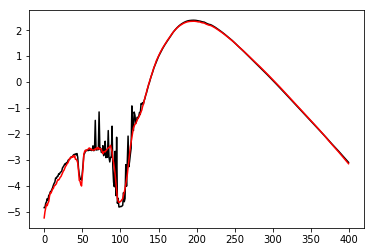

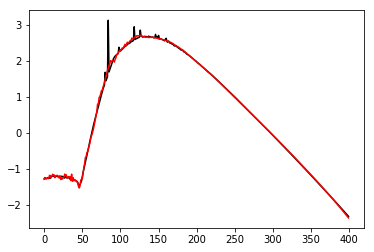

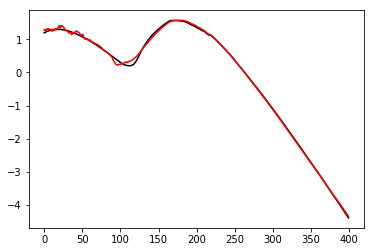

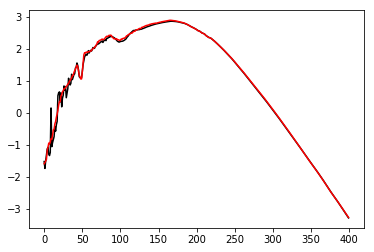

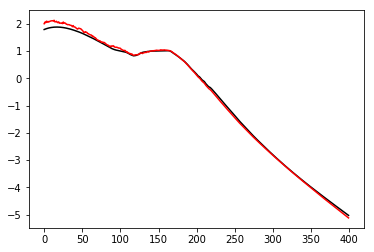

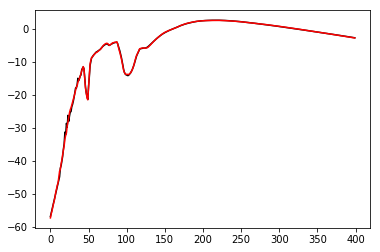

In [67]:
l=(0,1,2,3,4,5)
for i in l:
    plt.plot(cube[i],c='k')
    plt.plot(allsedshodlr[i],c='r')
    plt.show()